In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

In [2]:
#HYPERPARAMETERS
BATCH_SIZE = 4
EPOCHS = 13
STEP_SIZE = 0.0009
MOMENTUM = 0.9

In [3]:
#LOADING AND SPLITTING TRAIN & TEST DATA

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
#CNN FOR SHADOW AND TARGET MODELS OF CIFAR

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.batchnorm2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.batchnorm3 = nn.BatchNorm2d(64)
        
       
        self.fc1 = nn.Linear(4 * 4 * 64, 1024)
        self.fc2 =  nn.Linear(1024, 10)
        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.batchnorm1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.batchnorm2(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.batchnorm3(x)
        
        x = x.view(-1, 4 * 4 * 64)
        x = F.relu(self.fc1(x))
        out = F.softmax(self.fc2(x), dim = 1)
        return out

In [5]:
#FULLY CONNECTED MODEL FOR THE ATTACKER

class Net_Attack(nn.Module):
    def __init__(self):
        super(Net_Attack, self).__init__()
        
        self.fc1 = nn.Linear(10, 256)
        self.batchnorm1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 1024)
        self.batchnorm2 = nn.BatchNorm1d(1024)
        self.fc3 = nn.Linear(1024, 128)
        self.batchnorm3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 2)
        
        
    def forward(self, x):

        x = F.relu(self.fc1(x))
        x =  self.batchnorm1(x)
        x = F.relu(self.fc2(x))
        x =  self.batchnorm2(x)
        x = F.relu(self.fc3(x))
        x =  self.batchnorm3(x)
        out = F.softmax(self.fc4(x), dim = 1)
        return out

In [6]:
shadow = Net()
target = Net()
attack = Net_Attack()

In [7]:
shadow.load_state_dict(torch.load('shadow_model_CIFAR.pt'))
target.load_state_dict(torch.load('target_model_CIFAR.pt'))
attack.load_state_dict(torch.load('attack_model_CIFAR.pt'))

<All keys matched successfully>

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(shadow.parameters(), lr=STEP_SIZE, momentum = 0.9)
optimizer2 = torch.optim.SGD(target.parameters(), lr=STEP_SIZE, momentum = 0.9)
optimizer3 = torch.optim.SGD(attack.parameters(), lr=0.0002,  momentum = 0.9)

In [9]:
#TRAINING SHADOW & TARGET MODELS
for epoch in range(EPOCHS): 
    print (epoch)
    epoch_loss = 0
    for i, data in enumerate(trainloader, 0):
        images, labels = data
        

        #TRAIN SHADOW MODEL
        if i < 6000:
            optimizer1.zero_grad()
            outputs = shadow(images)
            loss1 = criterion(outputs, labels)
            loss1.backward()
            optimizer1.step()
            
            epoch_loss += outputs.shape[0] * loss1.item()

        # print epoch loss
        
        if i == 6000:
            
            print(epoch+1, epoch_loss / 24000)
            
            if epoch == 0:
                loss_per_epoch_shadow = np.array(epoch_loss) / 24000
                epoch_loss = 0
            else:
                loss_per_epoch_shadow = np.append(loss_per_epoch_shadow, np.array(epoch_loss) / 24000)
                epoch_loss = 0
            
            
            
            

            
        #TRAIN TARGET MODEL
        if i > 6000:     
            optimizer2.zero_grad()
            outputs = target(images)
            loss2 = criterion(outputs, labels)
            loss2.backward()
            optimizer2.step()
            
            
                            # print statistics
            epoch_loss += outputs.shape[0] * loss2.item()

    # print epoch loss
    print(epoch+1, epoch_loss / 24000)
    if epoch == 0:
        loss_per_epoch_target = np.array(epoch_loss) / 24000
    else:
        loss_per_epoch_target = np.append(loss_per_epoch_target, np.array(epoch_loss) / 24000)

            
            
#save both models
torch.save(shadow.state_dict(), "shadow_model_CIFAR.pt")
torch.save(target.state_dict(), "target_model_CIFAR.pt")

0


/home/fawzi/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


1 1.610046024998029
1 1.737409789443016
1
2 1.6012737218737603
2 1.7262568069497743
2
3 1.5945905650456746
3 1.718130899131298
3
4 1.5871869226296742
4 1.7111540405948957
4
5 1.581214155058066
5 1.7041946304837863
5
6 1.5757070191899936
6 1.698227822025617
6
7 1.5701583633820215
7 1.6927148880561194
7
8 1.5660102929671604
8 1.6893591323892276
8
9 1.5620577368338904
9 1.685766244371732
9
10 1.5583191503286362
10 1.6826960557103157
10
11 1.5551675324440002
11 1.6801159371733665
11
12 1.552022000392278
12 1.6781645805438359
12
13 1.5487883926828703
13 1.6759930723309517


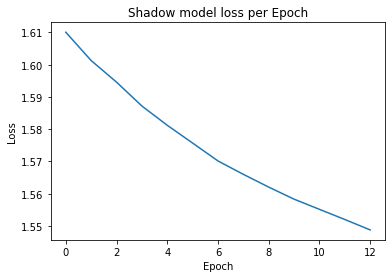

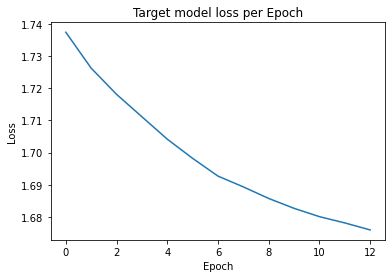

In [10]:
x = np.arange(EPOCHS)
plt.plot(x, loss_per_epoch_shadow)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Shadow model loss per Epoch")
plt.show()

plt.plot(x, loss_per_epoch_target)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Target model loss per Epoch")
plt.show()

In [11]:
def PRINT_ACC(predicted_shadow, predicted_target, ground_truth):
    predicted_shadow = torch.flatten(predicted_shadow).numpy()  
    predicted_target = torch.flatten(predicted_target).numpy()  
    ground_truth = torch.flatten(ground_truth).numpy()  
    print("Train Accuracy of shadow model is:",np.sum((predicted_shadow == ground_truth))/len(ground_truth))
    print("Shadow model's Precision for training dataset is:", precision_score(ground_truth, predicted_shadow, average='macro'))
    print("Shadow model's Recall for training dataset is:",recall_score(ground_truth, predicted_shadow, average='macro'))
    print("Test Accuracy of target model is:",np.sum((predicted_target == ground_truth))/len(ground_truth))
    print("Target model's Precision for testing dataset is:", precision_score(ground_truth, predicted_target, average='macro'))
    print("Target model's Recall for testing dataset is:",recall_score(ground_truth, predicted_target, average='macro'))

In [12]:
# TRAIN & TEST ACCURACY OF OUR SHADOW & TARGET MODELS

for i, data in enumerate(trainloader, 0):
    
    #first 6000 * 4 examples were trained on shadow model so we get train accuracy of shadow model
    # and test accuracy of target model
    if i > 6000:
        break
    images, labels = data
    outputs_shadow = shadow(images)
    outputs_target = target(images)
    if i ==0:
        _, Shadow = torch.max(outputs_shadow, 1)
        _, Target = torch.max(outputs_target, 1)
        predicted_shadow = Shadow
        predicted_target = Target
        ground_truth = labels
    else:
        _, Shadow = torch.max(outputs_shadow, 1)
        _, Target = torch.max(outputs_target, 1)
        predicted_shadow = torch.cat((predicted_shadow, Shadow), 0)
        predicted_target = torch.cat((predicted_target, Target), 0)
        ground_truth = torch.cat((ground_truth, labels), 0)

PRINT_ACC(predicted_shadow, predicted_target, ground_truth)


Train Accuracy of shadow model is: 0.9144309281786369
Shadow model's Precision for training dataset is: 0.9142849123964814
Shadow model's Recall for training dataset is: 0.9143289464018022
Test Accuracy of target model is: 0.6898016997167139
Target model's Precision for testing dataset is: 0.6896627824694759
Target model's Recall for testing dataset is: 0.6895998336028455


In [13]:
#TRAINING ATTACK MODEL
epochs = EPOCHS
loss_per_epoch = 0
for epoch in range(epochs):
    
    running_loss = 0
    epoch_loss = 0
    train_iterator = iter(trainloader)
    test_iterator = iter(testloader)

    for i in range(6000):
        
        optimizer3.zero_grad()
    
        if i%3==0:
            #Use images from shadow/target model's test dataset
            from_train = torch.zeros((BATCH_SIZE), dtype = torch.int64)
            images, labels = next(test_iterator)
        else:
            #Use images from shadow/target model's train dataset
            from_train = torch.ones((BATCH_SIZE), dtype = torch.int64)
            images, labels = next(train_iterator)
            
        posteriors = shadow(images)        
        outputs_attack = attack(posteriors)    
        loss3 = criterion(outputs_attack, from_train)
        loss3.backward()
        optimizer3.step()
       
        epoch_loss += outputs.shape[0] * loss3.item()

        # print statistics
        running_loss += loss3.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000), outputs_attack)
            running_loss = 0.0

    # print epoch loss
    print(epoch+1, epoch_loss / len(trainset))
    if epoch == 0:
        loss_per_epoch = np.array(epoch_loss) / len(trainset)
    else:
        loss_per_epoch = np.append(loss_per_epoch, np.array(epoch_loss) / len(trainset))
            
#Plot Epoch vs loss
x = np.arange(EPOCHS)

#SAVE ATTACK MODEL
torch.save(attack.state_dict(), "attack_model_CIFAR.pt")

[1,  2000] loss: 0.614 tensor([[0.0495, 0.9505],
        [0.0121, 0.9879],
        [0.0092, 0.9908],
        [0.5455, 0.4545]], grad_fn=<SoftmaxBackward>)
[1,  4000] loss: 0.607 tensor([[9.4906e-01, 5.0943e-02],
        [6.4656e-01, 3.5344e-01],
        [6.1040e-01, 3.8960e-01],
        [1.0223e-07, 1.0000e+00]], grad_fn=<SoftmaxBackward>)
[1,  6000] loss: 0.601 tensor([[8.2049e-01, 1.7951e-01],
        [6.4683e-01, 3.5317e-01],
        [1.0299e-05, 9.9999e-01],
        [4.4278e-02, 9.5572e-01]], grad_fn=<SoftmaxBackward>)
1 0.29145489324331286
[2,  2000] loss: 0.605 tensor([[0.0135, 0.9865],
        [0.0109, 0.9891],
        [0.0297, 0.9703],
        [0.3926, 0.6074]], grad_fn=<SoftmaxBackward>)
[2,  4000] loss: 0.600 tensor([[8.8641e-01, 1.1359e-01],
        [6.7492e-01, 3.2508e-01],
        [7.8578e-01, 2.1422e-01],
        [3.5344e-08, 1.0000e+00]], grad_fn=<SoftmaxBackward>)
[2,  6000] loss: 0.592 tensor([[6.9377e-01, 3.0623e-01],
        [6.4806e-01, 3.5194e-01],
        [1.1630e

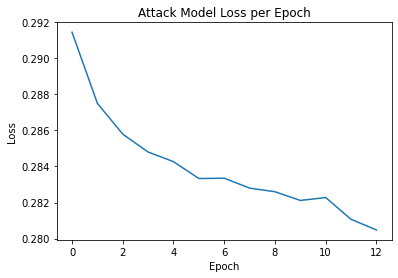

In [14]:
plt.plot(x, loss_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Attack Model Loss per Epoch')
plt.show()

In [15]:
def PRINT_ACC_ATTACK(predicted_shadow, predicted_target, ground_truth, Train = True):
    predicted_shadow = torch.flatten(predicted_shadow).numpy()
    predicted_target = torch.flatten(predicted_target).numpy()
    ground_truth = torch.flatten(ground_truth).numpy()  
    if Train == True:
        print ("Attack model Statistics using shadow model's Posteriors and training dataset")
        print (classification_report(ground_truth, predicted_shadow))
        print ("Attack model Statistics using target model's Posteriors and testing dataset")
        print (classification_report(ground_truth, predicted_target))
        print("Train Accuracy of attack model on Shadow Model's Posteriors ", 
              np.sum((predicted_shadow == ground_truth))/len(ground_truth),
              "Test Accuracy of attack model on Target Model's Posteriors ", 
              np.sum((predicted_target == ground_truth))/len(ground_truth),
              "Shadow model's Precision for training dataset is:",
              precision_score(ground_truth, predicted_shadow),
              "Shadow model's Recall for training dataset is:",
              recall_score(ground_truth, predicted_shadow))
              
    else:
        print ("Attack model Statistics using shadow model's Posteriors and testing dataset")
        print (classification_report(ground_truth, predicted_shadow))
        print ("Attack model Statistics using target model's Posteriors and training dataset")
        print (classification_report(ground_truth, predicted_target))
        print("Test Accuracy of attack model on Shadow Model's Posteriors ", 
              np.sum((predicted_shadow == ground_truth))/len(ground_truth),
              "Test Accuracy of attack model on Target Model's Posteriors ", 
              np.sum((predicted_target == ground_truth))/len(ground_truth),
              "Shadow model's Precision for testing dataset is:",
              precision_score(ground_truth, predicted_shadow),
              "Shadow model's Recall for testing dataset is:",
              recall_score(ground_truth, predicted_shadow))

In [16]:
# Checking Attack Model Train Accuracy
train_iterator = iter(trainloader)
test_iterator = iter(testloader)
for i in range(6000):

    from_train = torch.ones((BATCH_SIZE), dtype = torch.int64)

    if i%3==0:
            #Use images from shadow/target model's test dataset
            from_train = torch.zeros((BATCH_SIZE), dtype = torch.int64)
            images, labels = next(test_iterator)
    else:
        #Use images from shadow/target model's train dataset
        from_train = torch.ones((BATCH_SIZE), dtype = torch.int64)
        images, labels = next(train_iterator)
            

    # Finding Train Accuracy of Shadow Model
    posteriors_shadow = shadow(images)    
    outputs_attack_shadow = attack(posteriors_shadow)
    
    # Finding Train Accuracy of Target Model
    posteriors_target = target(images)   
    outputs_attack_target = attack(posteriors_target)

    
    if i ==0:
        _, Shadow = torch.max(outputs_attack_shadow, 1)
        _, Target = torch.max(outputs_attack_target, 1)

        predicted_shadow = Shadow
        predicted_target = Target
        ground_truth = from_train
    else:
        _, Shadow = torch.max(outputs_attack_shadow, 1)
        _, Target = torch.max(outputs_attack_target, 1)
        
        predicted_shadow = torch.cat((predicted_shadow, Shadow), 0)
        predicted_target = torch.cat((predicted_target, Target), 0)
        ground_truth = torch.cat((ground_truth, from_train), 0)
        

PRINT_ACC_ATTACK(predicted_shadow, predicted_target, ground_truth)

Attack model Statistics using shadow model's Posteriors and training dataset
              precision    recall  f1-score   support

           0       0.73      0.32      0.45      8000
           1       0.73      0.94      0.83     16000

    accuracy                           0.73     24000
   macro avg       0.73      0.63      0.64     24000
weighted avg       0.73      0.73      0.70     24000

Attack model Statistics using target model's Posteriors and testing dataset
              precision    recall  f1-score   support

           0       0.34      0.28      0.30      8000
           1       0.67      0.73      0.70     16000

    accuracy                           0.58     24000
   macro avg       0.50      0.50      0.50     24000
weighted avg       0.56      0.58      0.57     24000

Train Accuracy of attack model on Shadow Model's Posteriors  0.7349583333333334 Test Accuracy of attack model on Target Model's Posteriors  0.5785833333333333 Shadow model's Precision for train

In [17]:
# Checking Attack Model Test Accuracy
train_iterator = iter(trainloader)
test_iterator = iter(testloader)
for i in range(8000):

    if i<6000:
        if i%3==0:
            #Use images from shadow/target model's test dataset
            images, labels = next(test_iterator)
        else:
            #Use images from shadow/target model's train dataset
            images, labels = next(train_iterator)
        

    

    # For test we use only the last 2000*4 = 8000 images (last 2000 from test set of cifar10 and 6000 from trainset of cifar 10) 
    # both our shadow and target model have not previously seen these images 
    elif i>6000:
        
        if i%4==0:
            #Use images from shadow/target model's test dataset
            from_train = torch.zeros((BATCH_SIZE), dtype = torch.int64)
            images, labels = next(test_iterator)
        else:
            #Use images from shadow/target model's train dataset
            from_train = torch.ones((BATCH_SIZE), dtype = torch.int64)
            images, labels = next(train_iterator)
    
        posteriors_shadow = shadow(images)    
        outputs_attack_shadow = attack(posteriors_shadow)



        posteriors_target = target(images)
        #posteriors_target = torch.cat((posteriors_target, torch.reshape(labels, (BATCH_SIZE, 1))), 1)
        outputs_attack_target = attack(posteriors_target)

        if i ==6001:
            _, Shadow = torch.max(outputs_attack_shadow, 1)
            _, Target = torch.max(outputs_attack_target, 1)

            predicted_shadow = Shadow
            predicted_target = Target
            ground_truth = from_train
        else:
            _, Shadow = torch.max(outputs_attack_shadow, 1)
            _, Target = torch.max(outputs_attack_target, 1)
            predicted_shadow = torch.cat((predicted_shadow, Shadow), 0)
            predicted_target = torch.cat((predicted_target, Target), 0)
            ground_truth = torch.cat((ground_truth, from_train), 0)

PRINT_ACC_ATTACK(predicted_shadow, predicted_target, ground_truth, Train = False)


Attack model Statistics using shadow model's Posteriors and testing dataset
              precision    recall  f1-score   support

           0       0.57      0.28      0.37      1996
           1       0.79      0.93      0.86      6000

    accuracy                           0.77      7996
   macro avg       0.68      0.60      0.62      7996
weighted avg       0.74      0.77      0.74      7996

Attack model Statistics using target model's Posteriors and training dataset
              precision    recall  f1-score   support

           0       0.25      0.27      0.26      1996
           1       0.75      0.73      0.74      6000

    accuracy                           0.62      7996
   macro avg       0.50      0.50      0.50      7996
weighted avg       0.63      0.62      0.62      7996

Test Accuracy of attack model on Shadow Model's Posteriors  0.7681340670335167 Test Accuracy of attack model on Target Model's Posteriors  0.6160580290145072 Shadow model's Precision for testin